In [826]:
import numpy as np
import pandas as pd
import logging
import seaborn as sns
sns.set(style="darkgrid")

### Logger

In [855]:
#logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')

#logging.basicConfig
fh = logging.FileHandler('logger_lineplot.txt')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
logger.addHandler(fh)

'''
#For streaming only
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
ch.setFormatter(formatter)
logger.addHandler(ch)
'''

logger.info('This is a test log message.')

2018-09-15 12:46:55,216 - INFO - This is a test log message.
2018-09-15 12:46:55,216 - INFO - This is a test log message.


## Render graph functions

In [815]:
def renderGraph(db, workload):
    new_db = setCriteria(db, workload)
    graph = setLinePlot(new_db,workload)
    exportGraph(graph, workload)

def setCriteria(db, workload):
    return db[db.workload == workload]

def setLinePlot(db, workload):
    dbgraph = sns.lineplot(x=db.record_nbr, 
                          y=db.value, 
                          hue=db.database,
                          style=db.database,
                          sort=False,
                          legend='full',
                          markers=True,
                          dashes=True)
    handles, labels = dbgraph.get_legend_handles_labels()
    dbgraph.legend(handles=handles[1:], 
                   labels=labels[1:])
    dbgraph.set(xlabel='Number of Records', 
                ylabel="Time (seconds)")
    dbgraph.set_title(workload.upper())
    dbgraph
    
    return dbgraph

def setFileName(workload):
    name = workload.replace(" ", "")
    filename = "".join((name,'.png'))
    return filename

def exportGraph(graph, workload):
    name = setFileName(workload)
    fig = graph.get_figure()
    fig.savefig(name)
    fig.show
    return


In [894]:
class LinePlot():
    
    def __init__(self, db, workload):
        self.db = db
        self.workload = workload

    def renderGraph(self):
        new_db = self.setCriteria(self.db, self.workload)
        graph = self.setLinePlot(new_db, self.workload)
        self.exportGraph(graph, self.workload)
        return
    
    @staticmethod
    def setCriteria(db, workload):
        return db[db.workload == workload]
    
    @staticmethod
    def setLinePlot(db, workload):
        dbgraph = sns.lineplot(x=db.record_nbr, 
                              y=db.value, 
                              hue=db.database,
                              style=db.database,
                              sort=False,
                              legend='full',
                              markers=True,
                              dashes=True)
        handles, labels = dbgraph.get_legend_handles_labels()
        dbgraph.legend(handles=handles[1:], 
                       labels=labels[1:])
        dbgraph.set(xlabel='Number of Records', 
                    ylabel="Time (seconds)")
        dbgraph.set_title(workload.upper())
        dbgraph
        return dbgraph

    @staticmethod
    def setFileName(workload):
        extension = ".png"
        name = workload.replace(" ", "")
        filename = "".join((name,extension))
        return filename

    @staticmethod
    def exportGraph(graph, workload):
        name = setFileName(workload)
        fig = graph.get_figure()
        fig.savefig(name)
        fig.show
        return

## Iterate thru the output folder and get root path

In [864]:
import re

from os import path
from os import walk

class FileIterator:
    
    def __init__(self):
        self.path_root = 'output'

    def iterate_filenames(self):
        logger.debug('--iterate_filenames')
        
        databases = self.__iterate_database(self.path_root)
        files = self.__iterate_file(databases)
        return files

    def __iterate_database(self, root_dir):
        logger.debug('--iterate_database')
        path_dbs = []
        databases = ['redis','cassandra-cql']

        for database in databases:
            path_dbs.append(root_dir + '/' + database)
        return path_dbs

    def __iterate_file(self, path_dbs):
        logger.debug('--iterate_file')
        path_db_workload_files = []
        
        for path_db in path_dbs:
            for root, dirs, files in walk(path_db):  
                for filename in files:
                    if ".ipynb_checkpoints" in dirs:
                        pass
                    else: 
                        if ".swp" not in filename and ".txt~" not in filename:
                            path_db_workload_files.append(root + '/' + filename)
                            #logger.debug(root + '/' + filename)
        return path_db_workload_files

## Set dataframe values

In [861]:
class BuildDataFrame():
    
    def __init__(self, output, filename_path):
        self.output = output
        self.filename_path = filename_path
        self.file = filename_path.split(sep='/')
        self.filename = filename_path.split(sep='/')[len(filename_path.split(sep='/'))-1]
        
    def set_data_row(self):
        
        output_data = {}
        output_data['run'] = self.__set_run(self.filename)
        output_data['database'] = self.__set_database(self.filename_path)
        output_data['workload'] = self.__set_workload(self.filename)
        output_data['record_nbr'] = self.__set_record_nbr(self.filename)
        output_data['type'] = self.__set_type(self.output)
        output_data['label'] = self.__set_label(self.output)
        output_data['value'] = self.__set_value(self.output)

        return output_data

    def __set_runs(self,file):
        filename = (file[len(file)-1])
        col_run = filename.split(sep='.')[1]
        return col_run
    
    def __set_run(self,filename):
        col_run = filename.split(sep='.')[1]
        return col_run

    def __set_database(self, filename_path):
        database_name = ''
        col_database = filename_path.split(sep='/')[1]

        if(col_database == 'cassandra-cql'):
            database_name = 'Cassandra'
        else:
            database_name = col_database.title()

        return database_name

    def __set_workload(self, filename):
        col_workload = filename.split(sep='.')[2]

        w_type = col_workload[len(col_workload)-1]
        w_base = col_workload[:-1]

        workload_name = w_base + ' ' + w_type

        return workload_name
    
    def __set_record_nbr(self, filename):
        record_nbr = ''
        col_record = filename.split(sep='.')[0]

        if(col_record == '1k'):
            record_nbr = 1000
        elif(col_record == '10k'):
            record_nbr = 10000
        elif(col_record == '100k'):
            record_nbr = 100000
        elif(col_record == '1000k'):
            record_nbr = 1000000
        else:
            record_nbr = 100

        return record_nbr
    
    def __set_type(self, output):
        task_type = output.loc[0][0]
        return task_type[1:-1]
    
    
    def __set_label(self, output):
        task_label = output.loc[0][1].lstrip()
        return task_label

    def __set_value(self, output):
        seconds =  float(output.loc[0][2]) / 1000
        return seconds

### Read from csv files

In [880]:
class CSVReader():
    
    def __init__(self, filename_paths):
        self.filename_paths = filename_paths
        
    def get_data(self):
        data = []
        for filename_path in self.filename_paths:

            file = filename_path.split(sep='/')
            filename = (file[len(file)-1])
            database = file[1]

            if(database == 'mongodb'):
                csv_output = pd.read_csv(filename_path, skiprows=1, header=None)
            else:
                csv_output = pd.read_csv(filename_path, header=None)

            #TODO refractor 
            df_output = BuildDataFrame(csv_output, filename_path)
            data.append(df_output.set_data_row())

        return data

## __Main__

In [901]:
files = FileIterator()
file_paths = files.iterate_filenames()

csv_files = CSVReader(file_paths)
df_data = csv_files.get_data()

2018-09-15 13:09:49,460 - DEBUG - --iterate_filenames
2018-09-15 13:09:49,460 - DEBUG - --iterate_filenames
2018-09-15 13:09:49,466 - DEBUG - --iterate_database
2018-09-15 13:09:49,466 - DEBUG - --iterate_database
2018-09-15 13:09:49,470 - DEBUG - --iterate_file
2018-09-15 13:09:49,470 - DEBUG - --iterate_file


### Convert source file to dataFrame

In [874]:
db3 = pd.DataFrame(df_data, columns=['run','database','workload','record_nbr','type','label','value'])
db3.head()

,run,database,workload,record_nbr,type,label,value
0,load-1,Redis,workload a,100000,OVERALL,RunTime(ms),12.682
1,load-1,Redis,workload a,10000,OVERALL,RunTime(ms),1.691
2,load-1,Redis,workload a,1000,OVERALL,RunTime(ms),1.061
3,run-1,Redis,workload a,100000,OVERALL,RunTime(ms),6.523
4,run-1,Redis,workload a,10000,OVERALL,RunTime(ms),1.045


### Export to CSV

In [565]:
db3.to_csv('output_df.csv',sep=',')

### Render Graphs

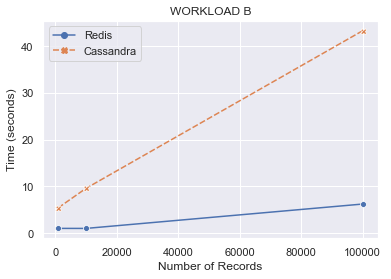

In [898]:
workload = 'workload b'
graph = LinePlot(db3,workload)
graph.renderGraph()

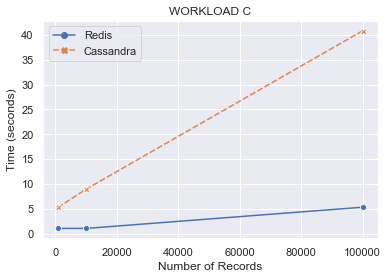

In [899]:
workload = 'workload c'
graph = LinePlot(db3,workload)
graph.renderGraph()